# Описание проекта

Одна из основных задач в этом наборе данных - предсказать на основе заданных характеристик пациента, есть ли у этого конкретного человека заболевание сердца или нет, а другая - экспериментальная задача по диагностике и получению различных сведений из этого набора данных, которые могли бы помочь в большем понимании проблемы.

In [61]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

from pandas_profiling import ProfileReport
from PIL import Image

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

# импорт моделей
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# импорт утилит
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# импорт метрик
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report,confusion_matrix



In [62]:
# Зафиксируем рандом
random.seed(42)

In [63]:
data = pd.read_csv('heart_disease_uci.csv')
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Признаки:
* `id` - уникальный индетификатор пациента
* `age` - возраст пациента в годах
* `origin` - место учебы
* `sex` - пол
* `cp` - тип боли в груди (typical angina, atypical angina, non-anginal, asymptomatic)
* `trestbps` -  кровяное давление в состоянии покоя
* `chol` - сывороточный холестерин в мг/дл
* `fbs` - если уровень сахара в крови натощак > 120 мг/дл (True, False)
* `restecg` - результаты электрокардиографии в состоянии покоя (normal, stt abnormality, lv hypertrophy)
* `thalach` -  достигнутая максимальная частота сердечных сокращений
* `exang` - стенокардия, вызванная физической нагрузкой (True/ False)
* `oldpeak` -  Депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом
* `slope` - наклон пикового сегмента ST упражнения
* `ca` - количество крупных сосудов (0-3), окрашенных при рентгеноскопии
* `thal` - (normal, fixed defect, reversible defect)

Целевой признак
* `num` -  категориальная переменная (0, 1, 2, 3 ,4), где значения это риски.

In [64]:
#profile = ProfileReport(data, title="Heart Disease UCI")
#profile.to_notebook_iframe()

В датасете присутствуют пропуски их 12.7% и отсутствуют дубликаты. Проанализируем признаки, избавимся от аномальных значений (если есть) и заполним пропуски.

In [65]:
def show_image (url):
    img = Image.open(url)
    display(img)

#### Числово признак age (Возраст)

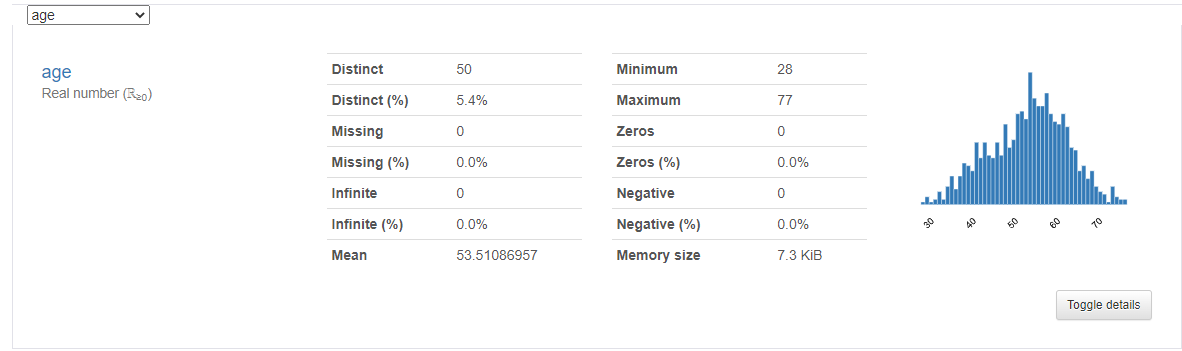

In [66]:
show_image('images/age.png')

* Пропуски отсутствуют, нулевые или аномальные значения так же.
* Q1 ~ Медиана ~ Q3  какого либо существенного перекоса нет, т.к квантели примерно равно удалены  от медианы.
* Минимум в 1.7 раза меньше чем Q1 
* Максимум в 1.3 раза больше чем Q3

В данном признаке есть редкие значения, но выбросами их не считаем. <br>
Распределение смещено влево.

#### Категориальный признак - sex (Пол)

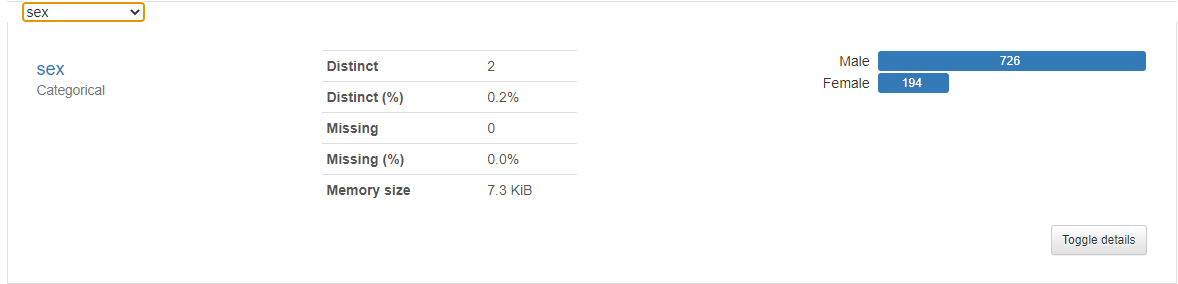

In [67]:
show_image('images/sex.png')

Отсутствуют пустые значения, значительный перекос в сторону мужчин:
* Male - 78.9% или 726 мужчин
* Female - 21.1% или 194 женщины

#### Категориальный признак - dataset (Где происходил сбор информации)

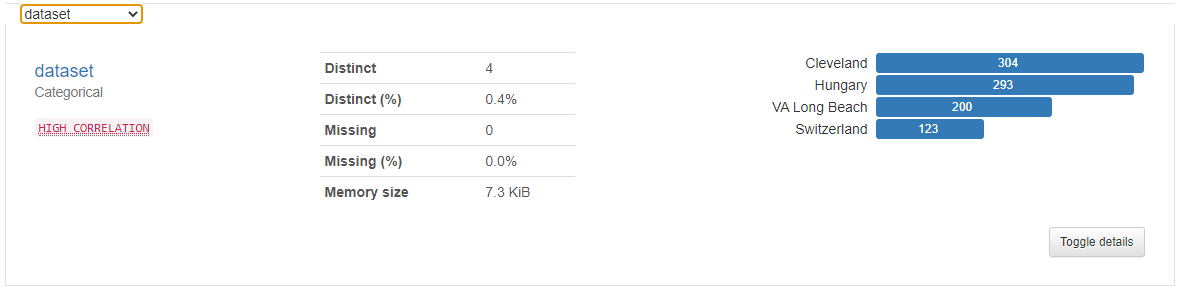

In [68]:
show_image('images/dataset.png')

* Пропуски отсутствуют

#### Категориальный признак - cp (Тип боли в груди)

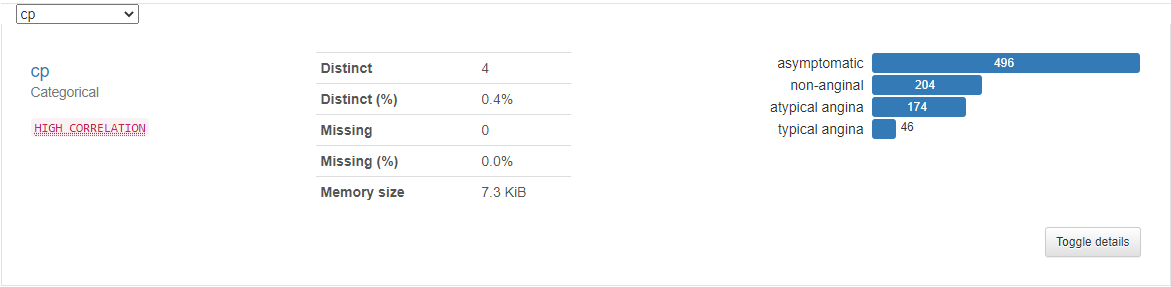

In [69]:
show_image('images/cp.png')

* Пропуски отсутствуют

#### Числовой признак trestbps (Кровяное давление в состоянии покоя)

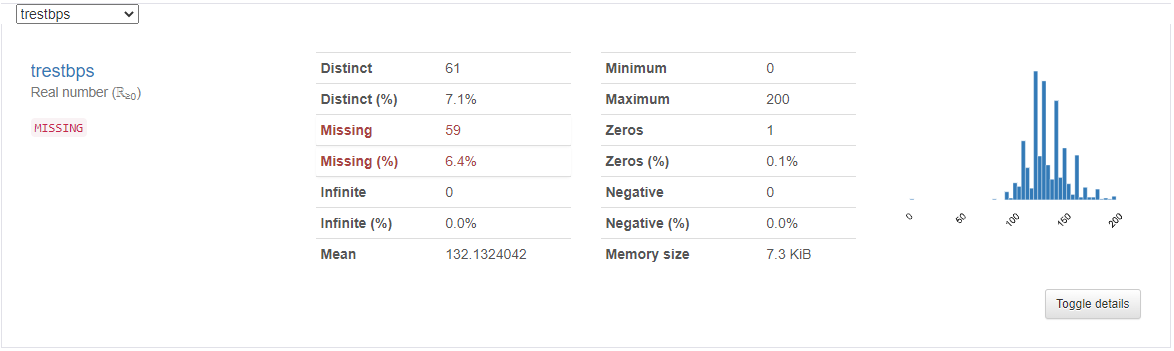

In [70]:
show_image('images/trestbps.png')

* Присутствуют пропуски и нулевые значения
* Q1 ~ Медиана ~ Q3
* Медиана меньше среднего, а значит больше людей обращаются с повышенным давлением 

Для заполнения пропусков сгруппируем данные по возрасту и месту сбора информации.

In [71]:
# Создадим еще один столбец category_age для распределения числового признака по категориям
# Необходимо для группировки и заполнения пустых значений признака trestbps

data['category_age'] = data['age'].apply(lambda x: 'young' if x <= 30 else 'middle' if x <= 50 else 'old')
data.head(3)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,category_age
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,old
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,old
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,old


In [72]:
# сгруппируем данные по возрасту и месту получения информации
# заполним пропуски исходя из полученного датасета

data_age_dataset = data.groupby(by=['category_age', 'dataset']).agg({'category_age':'count', 'trestbps': 'median'})
data_age_dataset.head(3)

data.loc[data['trestbps'].isna(), 'trestbps'] = data[data['trestbps'].isna()].apply(
    lambda row: data_age_dataset['category_age'][row['category_age']][row['dataset']], 
    axis=1)  

print('Кол-во пустых строк:', data[data['trestbps'].isna()]['trestbps'].count())   

Кол-во пустых строк: 0


#### Числовой признак - chol (сывороточный холестерин в мг/дл)

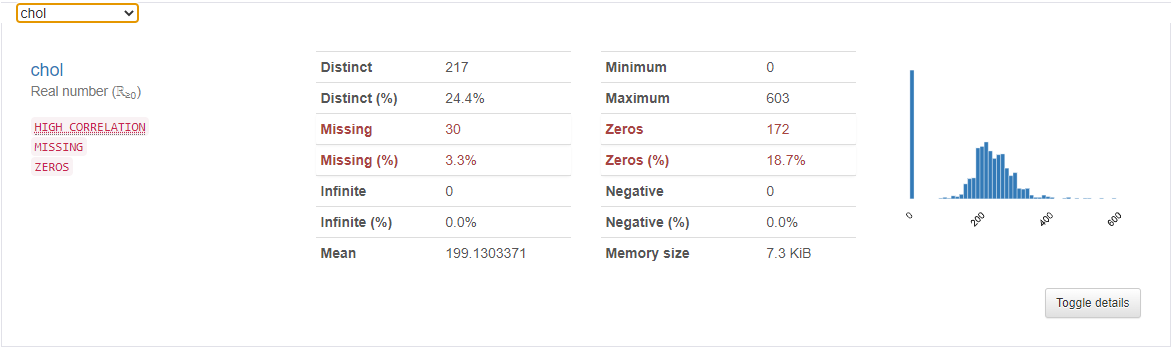

In [73]:
show_image('images/chol.png')

* Присутствуют пропуски и нулевые значения
* Q1 = Медиана = Q3
* Медиана меньше среднего, больше людей приходят с нормальным или низким уровнем холестерина.

Холестерин зависит от места обследования, выведем гистрограмму.

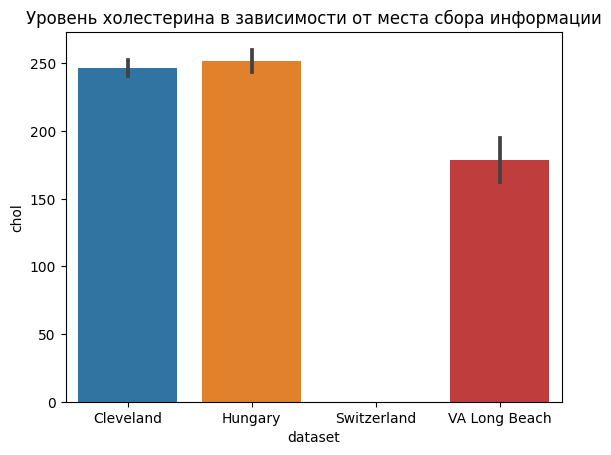

In [74]:
# воспользуемся библиотекой seaborn и matplotlib
# подпишем график

plt.title('Уровень холестерина в зависимости от места сбора информации')   
sns.barplot(x=data['dataset'], y=data['chol']);
plt.show()

В щвейцарии не измеряли уровнь холестерина. Пропусков 3.3%, возможно стоит удалить (?)

Заполним пропуски и посмотрим на нулевые значения.

In [75]:
# выведем кол-во нулевых зна
print('Кол-во нулевых значений:', data[data['chol'] == 0]['chol'].count())

Кол-во нулевых значений: 172


In [76]:
# сгруппируем данные по месту сбора информации
# и возврасту

data_age_dataset = data.groupby(by=['category_age', 'dataset']).agg({'category_age':'count', 'chol': 'median'})
data_age_dataset.head(3)

data.loc[data['chol'] == 0, 'chol'] = data[data['chol'] == 0].apply(
    lambda row: data_age_dataset['category_age'][row['category_age']][row['dataset']], 
    axis=1)
    
print('Кол-во нулевых значений:', data[data['chol'] == 0]['chol'].count())    

Кол-во нулевых значений: 0


In [77]:
# Норма кровяного давления 80 - 130 (найдем среднее т.к тут одно число. 105), 
# повышенное 90 - 140 и выше, (найдем среднее т.к тут одно число. 115)
# сделаем группировку по полу и категории кровяного давления

data['category_trestbps'] = data['trestbps'].apply(lambda x: 'hight' if x > 115 else 'normal' if x > 105 else 'low')

data_sex_cattrestbps = data.groupby(['sex', 'category_trestbps']).agg({'chol': 'mean'})

data.loc[data['chol'].isna(), 'chol'] = data.apply(lambda row: np.floor(data_sex_cattrestbps['chol'][row['sex']][row['category_trestbps']]), axis=1)

##### Категориальный признак - fbs (если уровень сахара в крови натощак > 120 мг/дл)

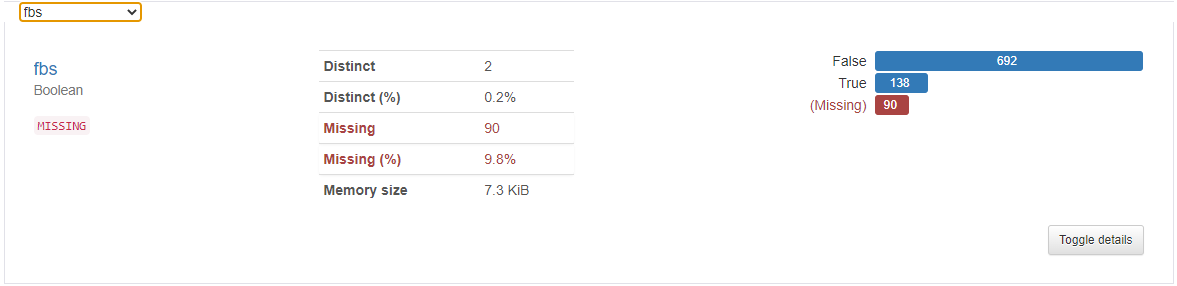

In [78]:
show_image('images/fbs.png')

* Есть пропуски 
* Значения только (True, False)

Заполним пропуски в данном признаке

In [79]:
# создадим доп. столбец, переведем True, False = 1,0
# сгруппируем данные по возрасту и месту сбора инфы
# получим среднее значение
# если среднее больше 0.5, то в пустое поле ставим 1 и наоборот
# таким образом заполним пустые поля 

data['fbs_b_int'] =  data['fbs'].apply(lambda x: 1 if x == True else 0 if x == False else -1);
data_age_dataset = data.groupby(by=['category_age', 'dataset']).agg({'category_age':'count', 'fbs_b_int': 'mean'})
 
data.loc[data['fbs'].isna(), 'fbs_b_int'] = data[data['fbs'].isna()].apply(
    lambda row: 1 if data_age_dataset['fbs_b_int'][row['category_age']][row['dataset']] > 0.5 else 0, 
    axis=1) 

data = data.drop(['fbs'], axis=1)


#### Категориальный признак - restecg (Результаты электрокардиографии в состоянии покоя)

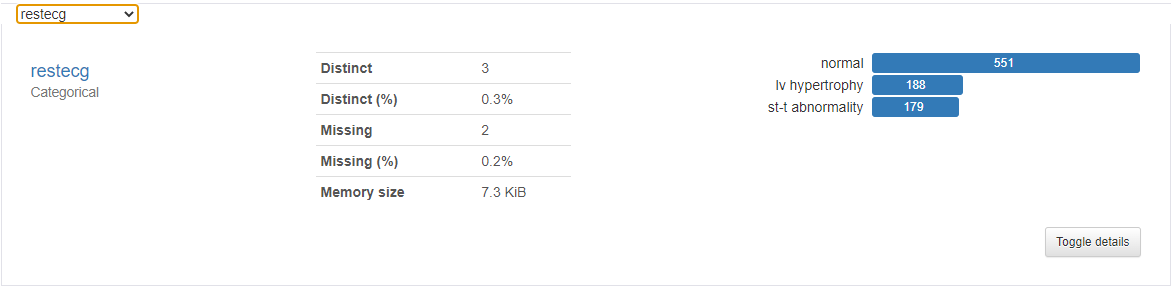

In [80]:
show_image('images/restecg.png')

* Есть пропуски

In [81]:
# получим уникальные значения
# заполним рандомом 2 значения

unique_restecg = data['restecg'].unique()
data.loc[data['restecg'].isna(), 'restecg'] = [unique_restecg[random.randint(0, 2)] for x in range(data[data['restecg'].isna()]['restecg'].shape[0])]

#### Числовой признак - thalch (достигнутая максимальная частота сердечных сокращений)

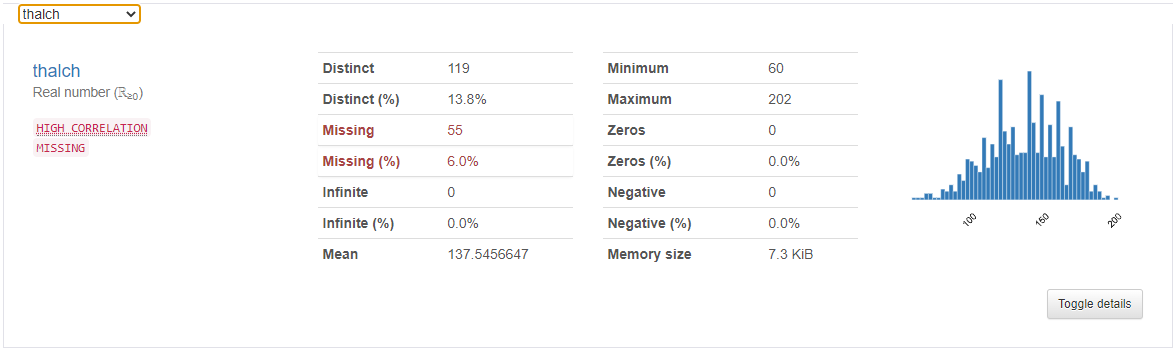

In [82]:
show_image('images/thalch.png')

* Есть пустые значения
* Медиана меньше среднего, а значит у большинства людей макс частота не превышает медианного значения

In [83]:
# заполним рандомом от минимального до максимального значения(?)
print('Минимальное значение:', data['thalch'].min())
print('Максимальное значение:', data['thalch'].max())
print('Кол-во пустых строк до:', data[data['thalch'].isna()].shape[0])

data.loc[data['thalch'].isna(), 'thalch'] = [random.randint(data['thalch'].min(), data['thalch'].max()) 
for x in range(data[data['thalch'].isna()].shape[0])]

print('Кол-во пустых строк после:', data[data['thalch'].isna()].shape[0])

Минимальное значение: 60.0
Максимальное значение: 202.0
Кол-во пустых строк до: 55
Кол-во пустых строк после: 0


#####  Категориальный признак - exang (стенокардия, вызванная физической нагрузкой)

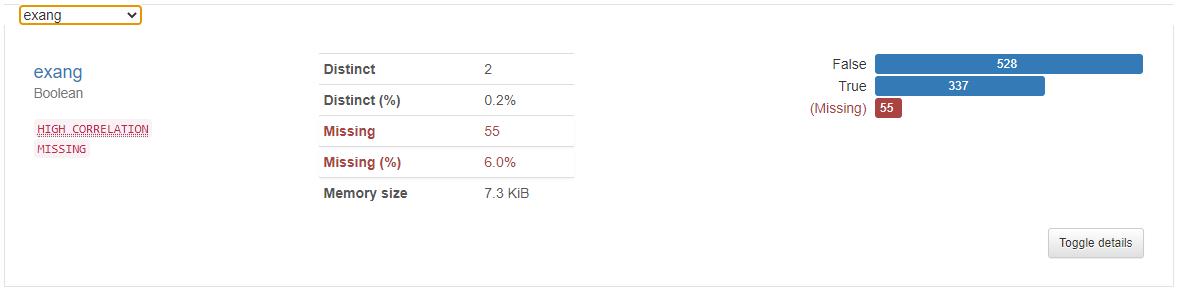

In [84]:
show_image('images/exang.png')

* Есть пропуски
* Значения только (True, False)

Пустые значения могли быть вызваны отсутствием физ. нагрузки. Выведем пустые значения.

In [85]:
# переведем True, False в 1, 0
# заполним рандомными 0 и 1
print('Кол-во пустых строк до:', data[data['exang'].isna()].shape[0])

data.loc[data['exang'].isna(), 'exang'] = [random.randint(0, 1) for x in range(data[data['exang'].isna()].shape[0])]
data['exang'] = data['exang'].apply(lambda x: 1 if x == True else 0)

print('Кол-во пустых строк после:', data[data['exang'].isna()].shape[0])


Кол-во пустых строк до: 55
Кол-во пустых строк после: 0


#### Числовой признак - oldpeak (Депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом)

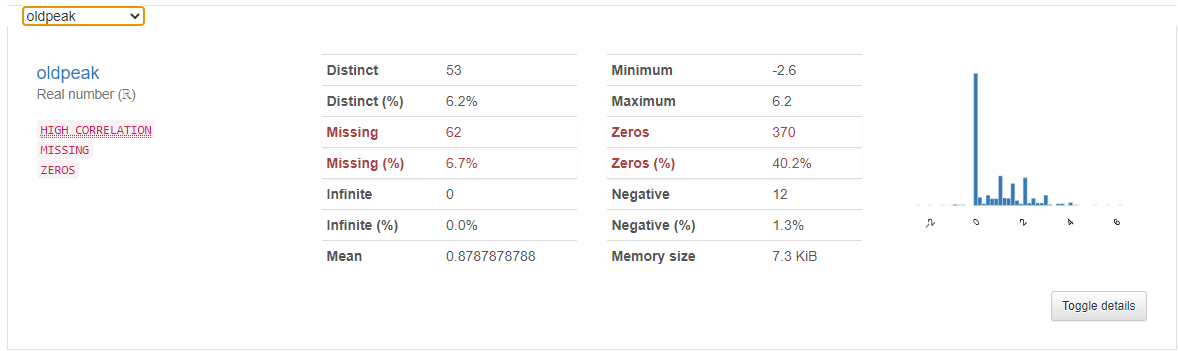

In [86]:
show_image('images/oldpeak.png')

* Есть пропуски
* Не понятна природа данных, есть ли выбросы и т.д

In [87]:
print('Минимальное значение:', data['oldpeak'].min())
print('Максимальное значение:', data['oldpeak'].max())
print('Кол-во пустых строк до:', data[data['oldpeak'].isna()].shape[0])
data.loc[data['oldpeak'].isna(), 'oldpeak'] = [random.randint(int(data['oldpeak'].min()), int(data['oldpeak'].max())) for x in range(data[data['oldpeak'].isna()].shape[0])]
print('Кол-во пустых строк после:', data[data['oldpeak'].isna()].shape[0])

Минимальное значение: -2.6
Максимальное значение: 6.2
Кол-во пустых строк до: 62
Кол-во пустых строк после: 0


#### Категориальный признак - slope (Наклон пикового сегмента ST упражнения)

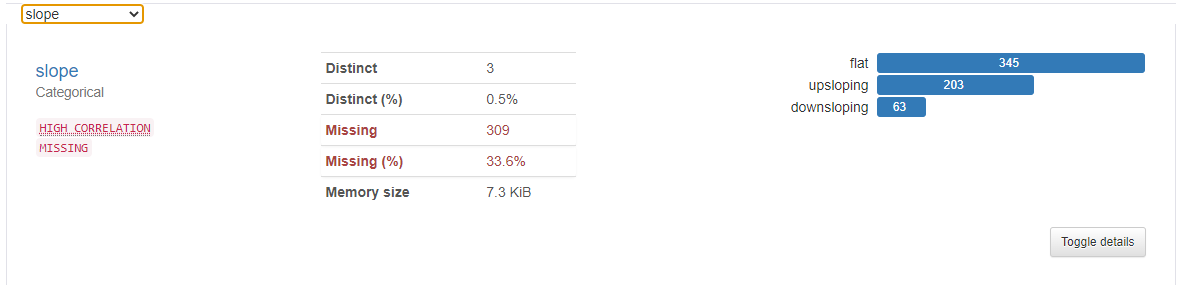

In [88]:
show_image('images/slope.png')

* 33.6% пропусков

In [89]:
# рандомим заполнение
data.loc[data['slope'].isna(), 'slope'] = data[data['slope'].isna()]['slope'].apply(lambda x: data['slope'].unique()[random.randint(0, 2)])

#### Категориальный признак - ca (количество крупных сосудов (0-3), окрашенных при рентгеноскопии)

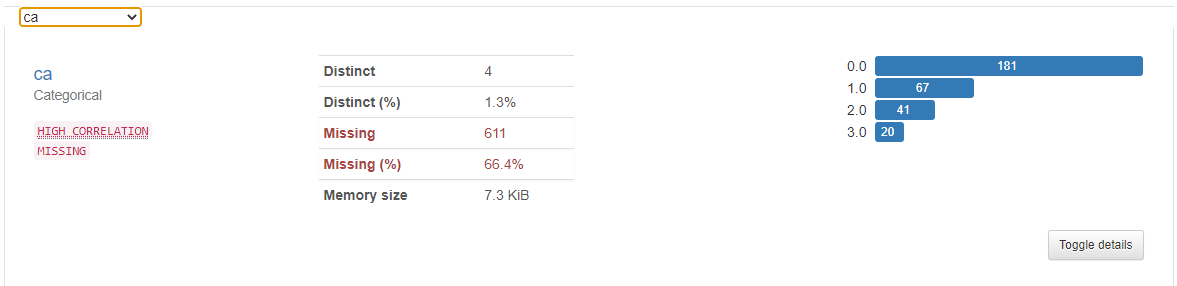

In [90]:
show_image('images/ca.png')

* 66.4% пропусков
* Из-за пропусков тип данных float, а не int

In [91]:
# рандомим заполнение
data.loc[data['ca'].isna(), 'ca'] = data[data['ca'].isna()]['ca'].apply(lambda x: data['ca'].unique()[random.randint(0, 3)])

#### Категориальный признак - thal (Состояние сердца)

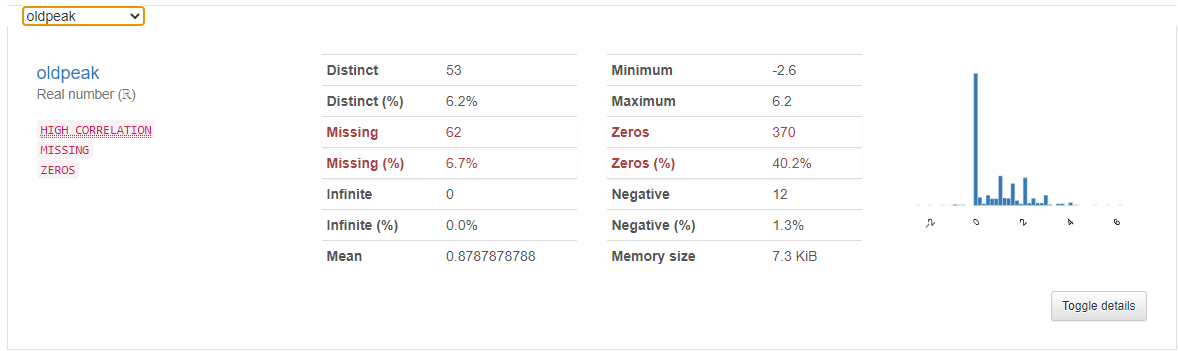

In [92]:
show_image('images/oldpeak.png')

* Большое кол-во пропусков 52.8%

In [93]:
# рандомим заполнение
data.loc[data['thal'].isna(), 'thal'] = [data['thal'].unique()[random.randint(0, 2)] 
for x in range(data[data['thal'].isna()].shape[0])]

In [94]:
# итоговый датасет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 920 non-null    int64  
 1   age                920 non-null    int64  
 2   sex                920 non-null    object 
 3   dataset            920 non-null    object 
 4   cp                 920 non-null    object 
 5   trestbps           920 non-null    float64
 6   chol               920 non-null    float64
 7   restecg            920 non-null    object 
 8   thalch             920 non-null    float64
 9   exang              920 non-null    int64  
 10  oldpeak            920 non-null    float64
 11  slope              920 non-null    object 
 12  ca                 920 non-null    float64
 13  thal               920 non-null    object 
 14  num                920 non-null    int64  
 15  category_age       920 non-null    object 
 16  category_trestbps  920 non

In [95]:
# выбраные столбцы приведем к целому число
data[['trestbps', 'chol', 'thalch', 'ca']] = data[
     ['trestbps', 'chol', 'thalch', 'ca']
].astype('int')

#### Исследовательский анализ данных

In [96]:
# вспомогательная функция для отображения графиков
def show_figure(filter_column, show_column, marker=[], start_marker_index=0, names=[], type='Box'):

    fig = go.Figure()
   
    if show_column == 'trestbps' and type == 'Box':
        fig.add_trace(go.Box(y=data[show_column].values , name='Давление', marker_color = marker[0], boxmean=True))
    elif show_column == 'trestbps' and type == 'Violin':
        fig.add_trace(go.Violin(y=data[show_column].values , name='Все пациенты', marker_color = 'green'))
    elif filter_column == 'sex' and show_column == 'chol':
        fig.add_trace(go.Box(y=data[show_column].values , name='Холестерин', marker_color = marker[0], boxmean=True))
    elif filter_column == 'num' and show_column == 'chol':
        fig.add_trace(go.Violin(y=data['chol'].values , name='Все пациенты', marker_color = 'green'))

    values = sorted(data[filter_column].unique());
    print(values)
    for index in range(len(values)):
        if type == 'Box':
            fig.add_trace(go.Box(y=data[data[filter_column] == values[index]][show_column].values, name=names[index], marker_color=marker[index + start_marker_index], boxmean = True))
        elif type == 'Violin':
            fig.add_trace(go.Violin(y=data[data[filter_column] == values[index]][show_column].values, name=names[index], marker_color=marker[index + start_marker_index]))
            #fig.update_layout(title = 'Уровень кровянного давления в зависимости от степени болезни сердца', yaxis_title = 'Кровяное давление', title_x = 0.5)    

    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
    fig.show()

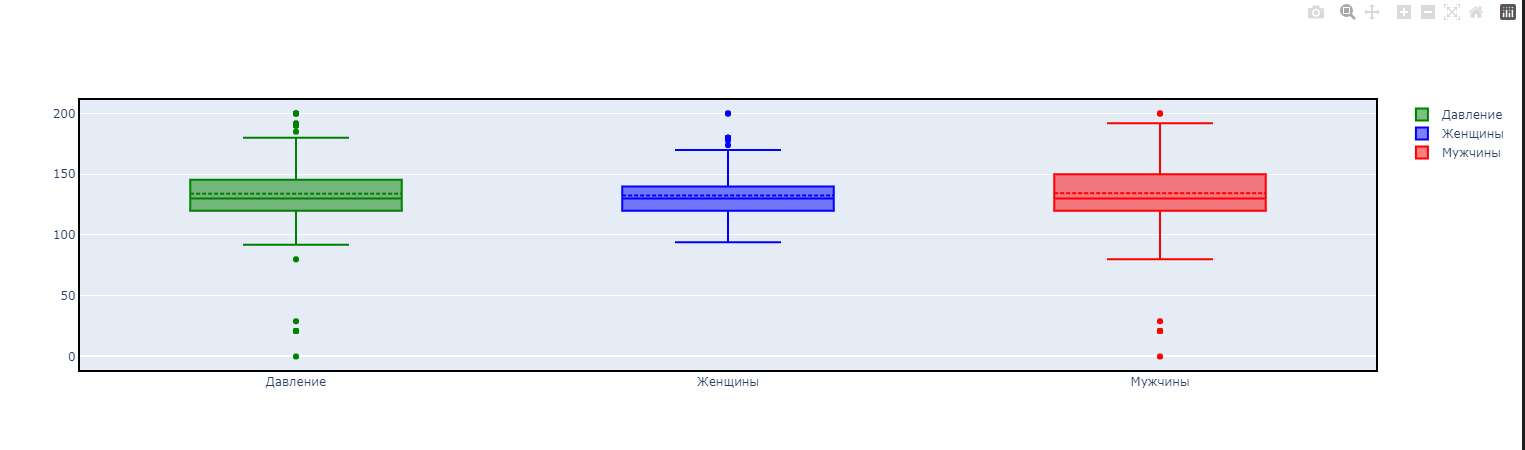

In [97]:
#show_figure('sex', 'trestbps', marker=['green', 'blue', 'red'], start_marker_index=1, names=['Женщины', 'Мужчины'])
show_image('images/sex_trestbps.png')

Диапазон кровянного давления 70 - 150, может быть и выше, но это признаки заболевания, а вот экстремально низкие можно считать выбросами. Выбросами здесь могут быть точки у нижней границы усов для категории мужчин. 

In [98]:
# удалим значения давления ниже 30
data = data.query('trestbps > 30')

Предположим, что кровянное давление зависит от состояния сердца.

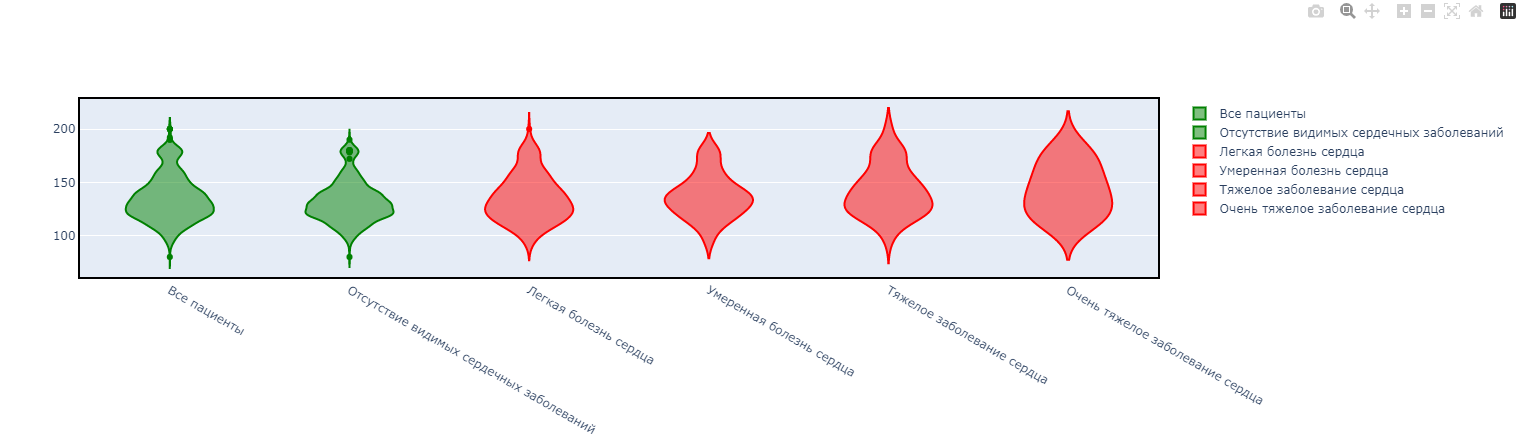

In [99]:
names=['Отсутствие видимых сердечных заболеваний', 
       'Легкая болезнь сердца', 
       'Умеренная болезнь сердца', 
       'Тяжелое заболевание сердца', 
       'Очень тяжелое заболевание сердца']
#show_figure('num', 'trestbps', marker=['green', 'red', 'red', 'red', 'red', 'red'], start_marker_index=0, names=names, type='Violin')
show_image('images/num_trestbps.png')

При заболевании сердца нижняя планка кровяного давления с 80, поднимается от 90 и выше в зависимости от степени заболевания.

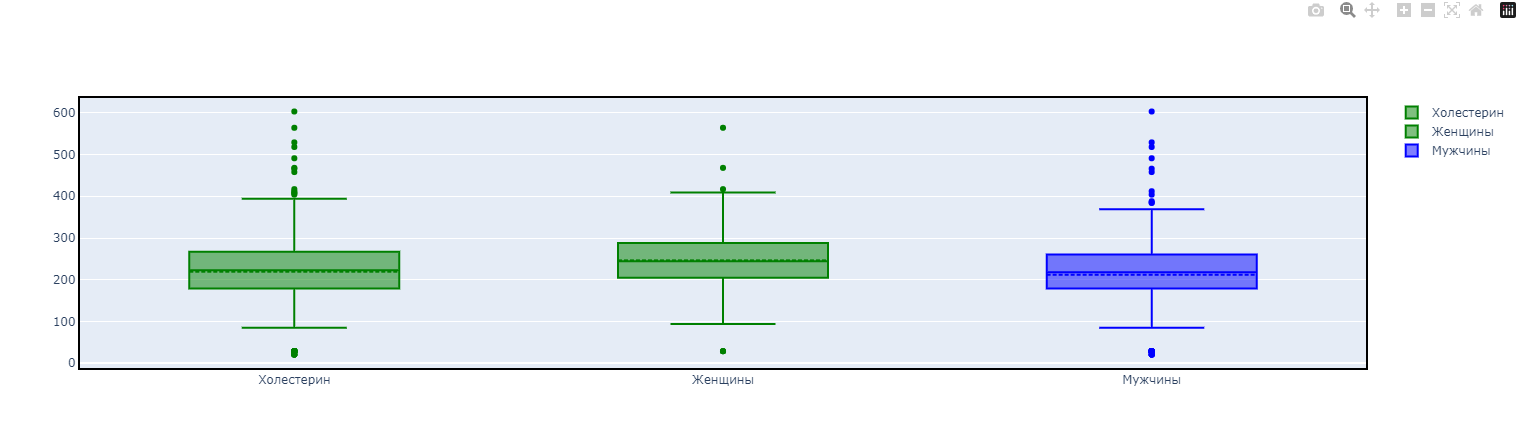

In [100]:
names = ['Женщины', 'Мужчины']
#show_figure('sex', 'chol', marker=['green', 'blue', 'red'], start_marker_index=0, names=names, type='Box')
show_image('images/sex_chol.png')

In [101]:
# удалим значения холестерина ниже 30
data = data.query('chol > 30')

Исследуем уровень холестерина в зависимости от степени болезни сердца.

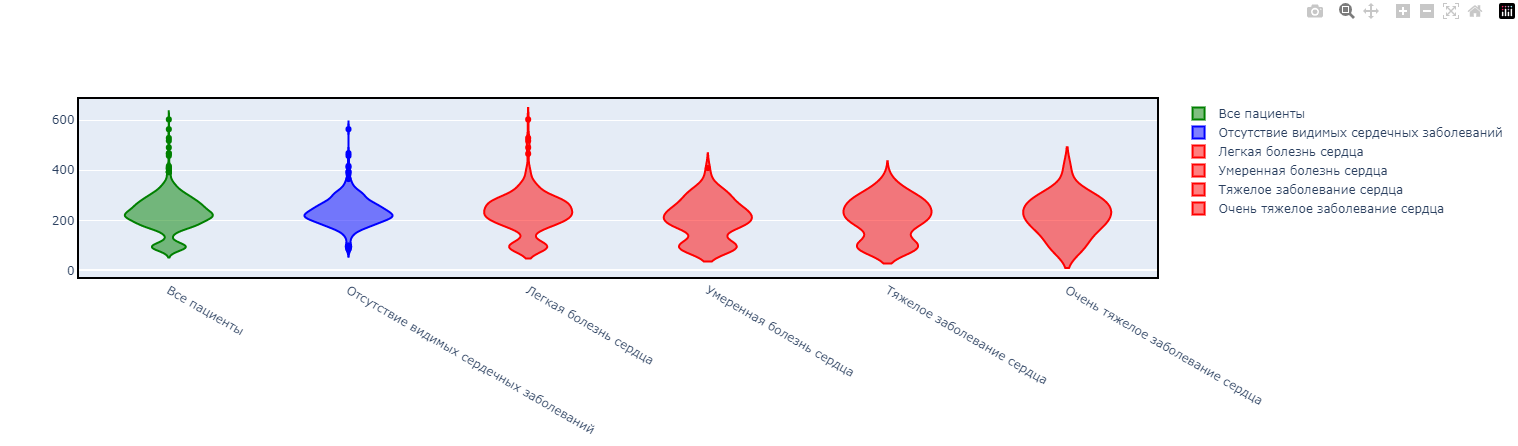

In [102]:
names = ['Отсутствие видимых сердечных заболеваний', 
         'Легкая болезнь сердца', 
         'Умеренная болезнь сердца', 
         'Тяжелое заболевание сердца', 
         'Очень тяжелое заболевание сердца']
#show_figure('num', 'chol', marker=['blue', 'red', 'red', 'red', 'red', 'red'], start_marker_index=0, names=names, type='Violin')
show_image('images/num_chol.png')

Уровень холестерина меняется в зависимости от болезни сердца, чем диагноз сложнее, тем уровень холестерина выше. Есть так же здоровые люди, но с высоким уровнем холестерина.

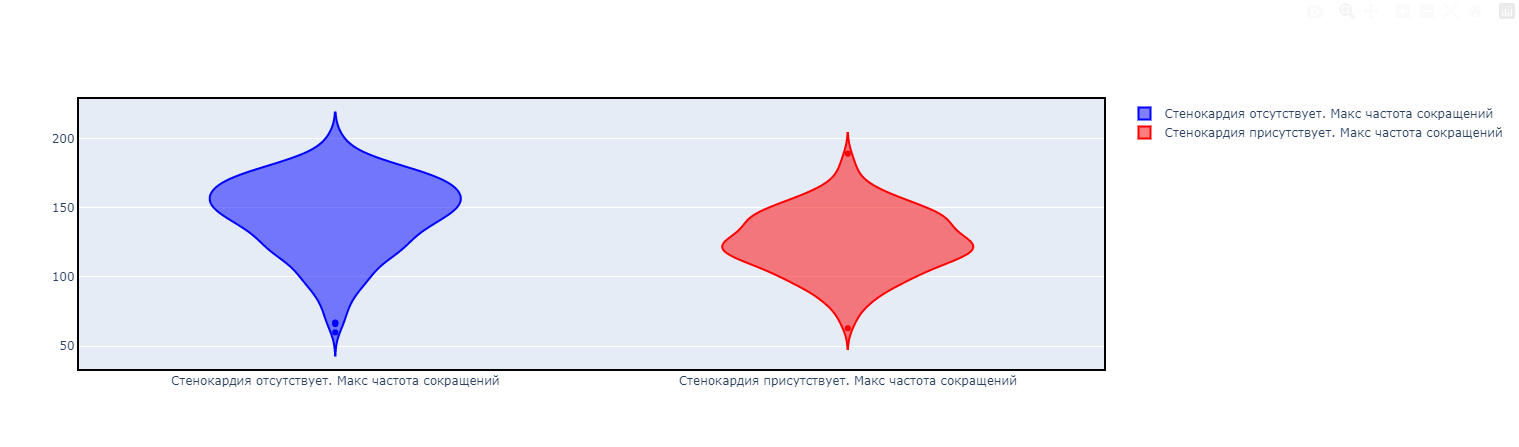

In [103]:
names = ['Стенокардия отсутствует. Макс частота сокращений', 'Стенокардия присутствует. Макс частота сокращений']
#show_figure('exang', 'thalch', marker=['blue', 'red'], start_marker_index=0, names=names, type='Violin')
show_image('images/exang_thalch.png')

При стенокардии максимальная частота сердечных сокращений ниже, но есть максимальные/минимальные значения сильно выбивающиеся из общей картины.

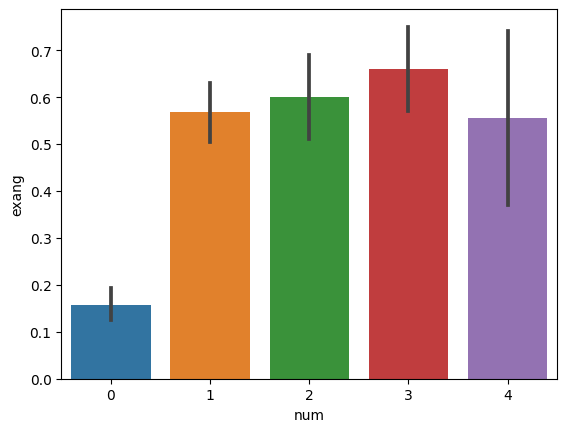

In [104]:
# построим гистограмму
sns.barplot(data=data, y='exang', x='num')
plt.show()

Шанс стенокардии у человека с болезнью сердца более высок. Сравним электрокардиография у больных и не больных пациентов. 

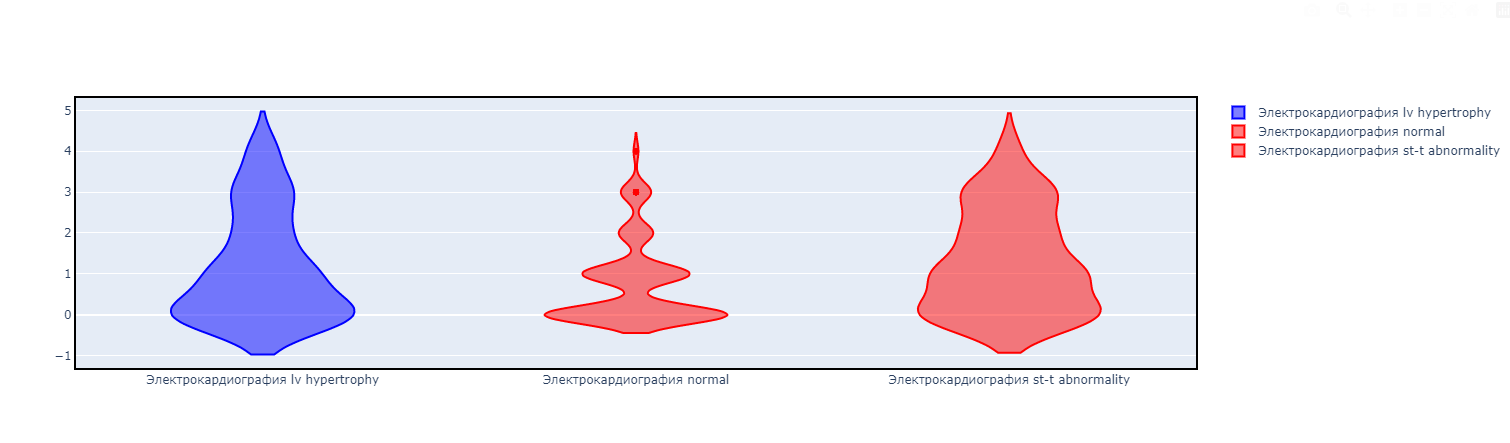

In [105]:
names = ['Электрокардиография lv hypertrophy', 'Электрокардиография normal', 'Электрокардиография st-t abnormality']
#show_figure('restecg', 'num', marker=['blue', 'red', 'red'], start_marker_index=0, names=names, type='Violin')
show_image('images/restecg_num.png')

По результатам электрокардиографи болезнь сердца не определить.

### Baseline модель

In [106]:
# Удалим вспомогательные столбцы
# Переведем целевой признак в бинарную классификацию
# Т.к  0 - не болен, иначе болен (1, 2, 3)

data = data.drop(['category_age', 'category_trestbps'], axis=1)
data['num'] = data['num'].apply(lambda x: 1 if x > 0 else 0)

In [107]:
# Выведем числовые признаки
numerical_features = data.drop(['num'], axis=1).select_dtypes(include='number').columns.tolist()
print(f'Числовые признаки ({len(numerical_features)}):', '\n')
print(numerical_features)

Числовые признаки (9): 

['id', 'age', 'trestbps', 'chol', 'thalch', 'exang', 'oldpeak', 'ca', 'fbs_b_int']


In [108]:
# Выведем категориальные признаки
categorical_features = data.select_dtypes(exclude='number').columns.tolist()
print(f'Категориальные признаки ({len(categorical_features)}):', '\n')
print(categorical_features) 

Категориальные признаки (6): 

['sex', 'dataset', 'cp', 'restecg', 'slope', 'thal']


In [109]:
# Разобьем данные на трейновую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(data.drop(['num'], axis=1), 
                                                                              data['num'], 
                                                                              test_size=0.4, 
                                                                              random_state=0)

In [110]:
# используем порядковое кодирования для категориальных переменных
enc = OrdinalEncoder() 
enc.fit(features_train)

features_train[categorical_features] = enc.set_params(encoded_missing_value=-1).fit_transform(features_train[categorical_features]) 
features_valid[categorical_features] = enc.set_params(encoded_missing_value=-1).fit_transform(features_valid[categorical_features])

In [111]:
# приведем числовые признаки к единному формату
scaler = StandardScaler()
scaler.fit(features_train[numerical_features])

features_train[numerical_features] = scaler.transform(features_train[numerical_features])
features_valid[numerical_features] = scaler.transform(features_valid[numerical_features])

In [112]:
# Базовая модель Решающее дерево
model = DecisionTreeClassifier(random_state=0)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

baseline_metrics = pd.DataFrame({
    'Модель': ['Решающее дерево'],
    'Recall': recall_score(target_valid, predicted_valid)
})

print(classification_report(target_valid, predicted_valid))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       162
           1       0.83      0.82      0.82       190

    accuracy                           0.81       352
   macro avg       0.81      0.81      0.81       352
weighted avg       0.81      0.81      0.81       352



In [113]:
# Базовая модель Лог. регрессия
model = LogisticRegression(random_state=0, solver='liblinear')

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)


baseline_metrics = pd.concat([baseline_metrics] + [pd.DataFrame({
    'Модель': ['Лог. регрессия'],
    'Recall': recall_score(target_valid, predicted_valid)
})])

print(classification_report(target_valid, predicted_valid))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       162
           1       0.82      0.83      0.83       190

    accuracy                           0.81       352
   macro avg       0.81      0.81      0.81       352
weighted avg       0.81      0.81      0.81       352



In [114]:
# Базовая модель Случайный лес
model = RandomForestClassifier(random_state=0)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

baseline_metrics = pd.concat([baseline_metrics] + [pd.DataFrame({
    'Модель': ['Случайный лес'],
    'Recall': recall_score(target_valid, predicted_valid)
})])

print(classification_report(target_valid, predicted_valid))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       162
           1       0.84      0.91      0.87       190

    accuracy                           0.86       352
   macro avg       0.86      0.85      0.86       352
weighted avg       0.86      0.86      0.86       352



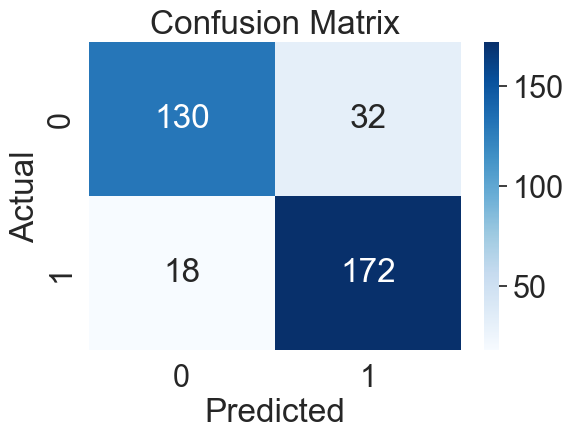

In [115]:
matrix = confusion_matrix(target_valid, predicted_valid)
sns.set(rc={"figure.figsize":(6, 4)}, font_scale=2)
sns.heatmap(matrix, annot=True, cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

### Разработка модели ML

C:\Users\User\AppData\Local\Temp\ipykernel_14380\1116144079.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



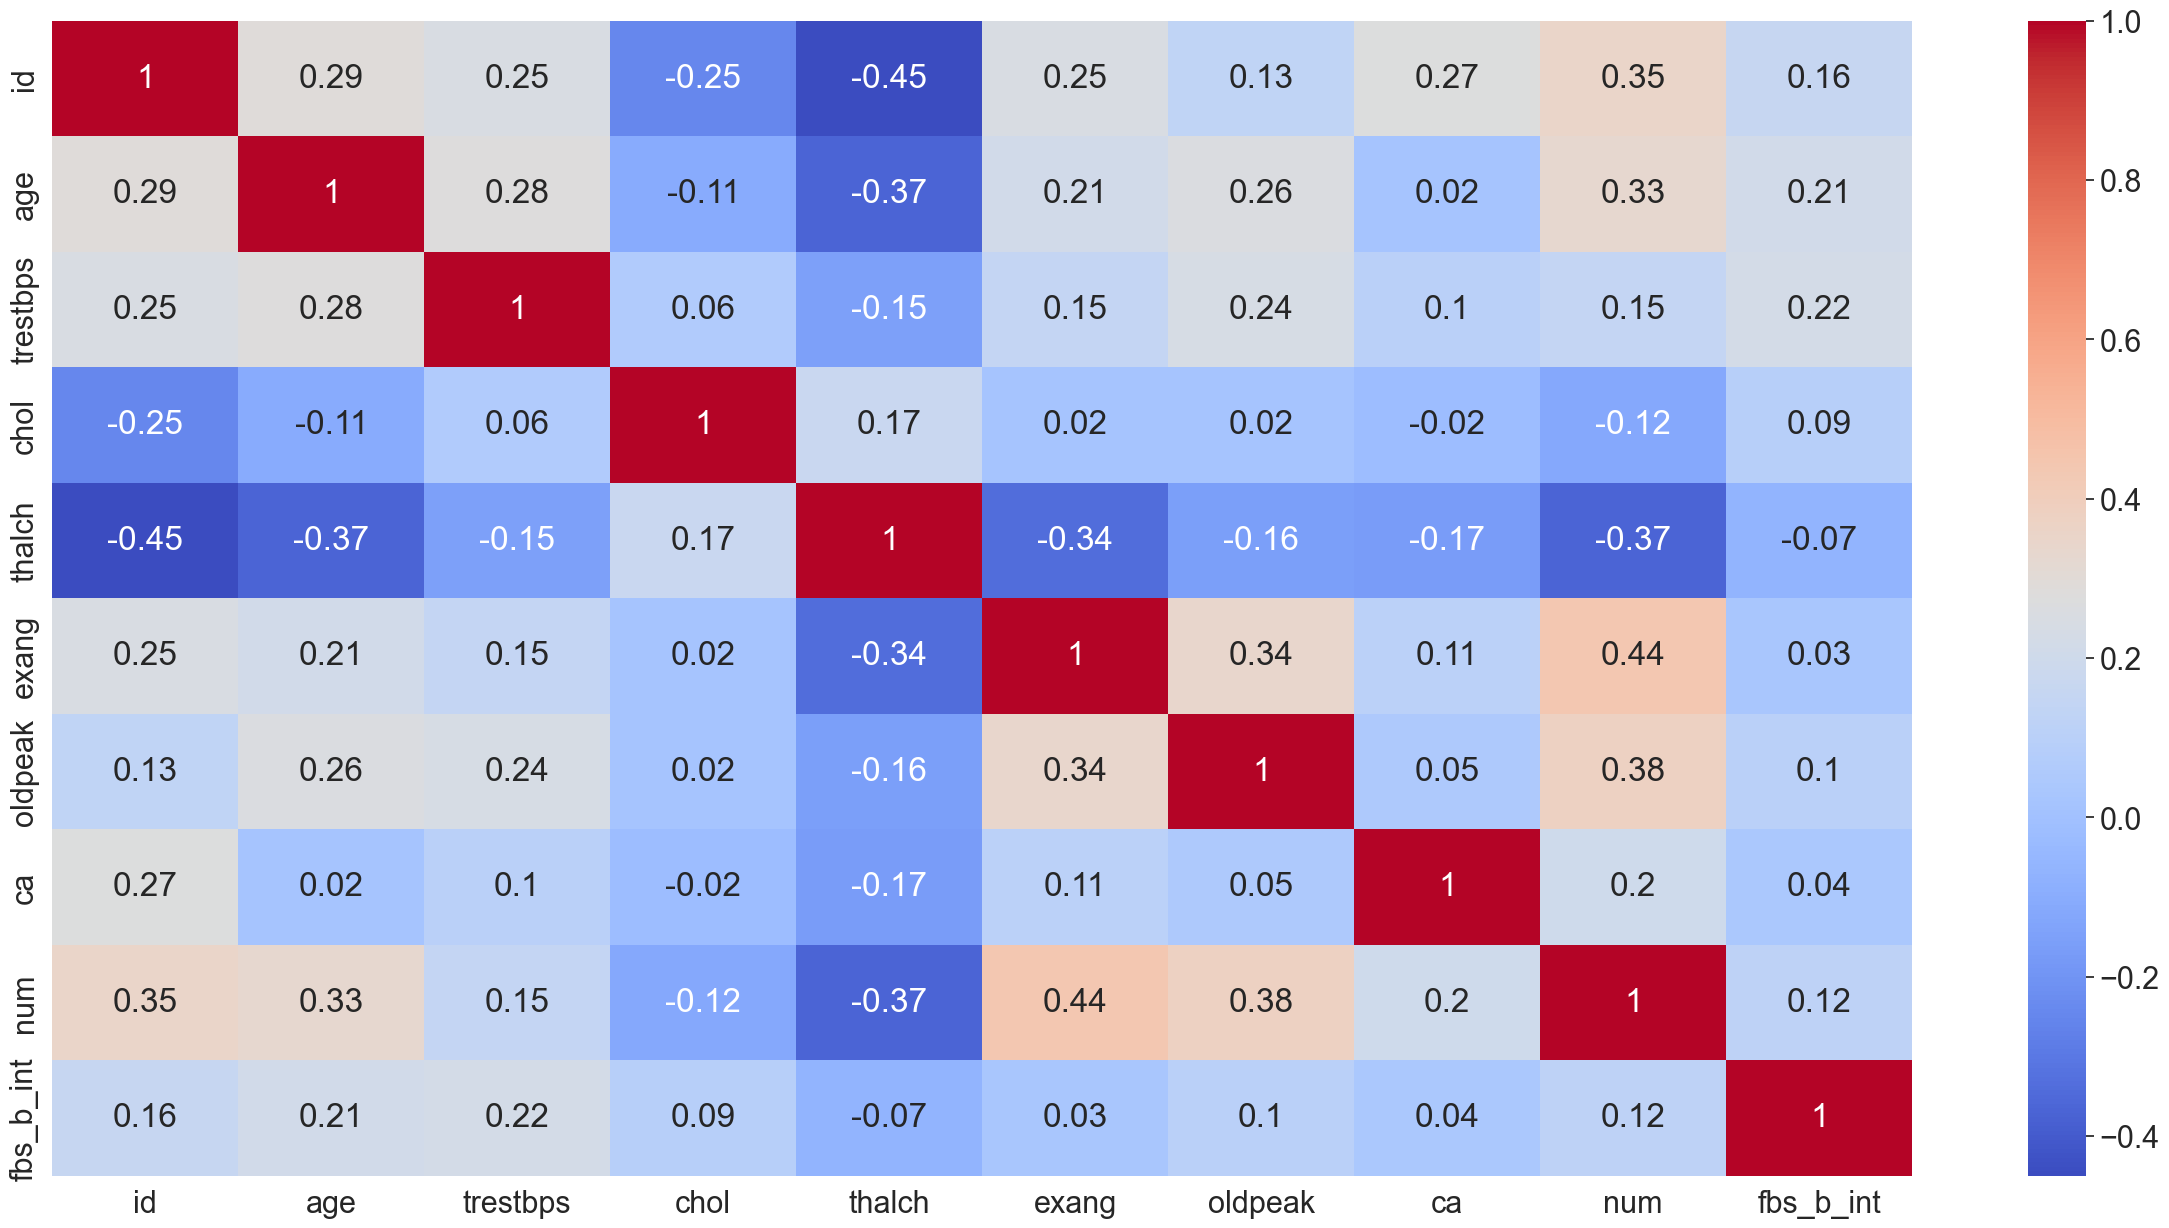

In [116]:
# построим матрицу корреляции
corr_matrix = data.corr().round(2)
sns.set(rc={"figure.figsize":(30, 15)}, font_scale=2)
sns.heatmap(corr_matrix, annot = True, fmt='.2g',cmap= 'coolwarm')
plt.show()


Все признаки являются значимыми для целевого признака. Посмотрим на балансировку классов.

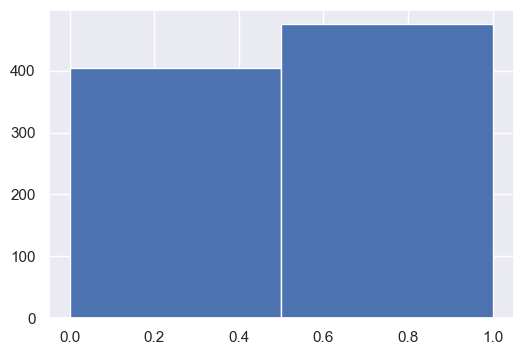

In [117]:
# построим гистограмму на 2а бина
sns.set(rc={"figure.figsize":(6, 4)})
data['num'].hist(bins=2)
plt.show()

Присутствует небольшой дисбаланс в сторонку класса "1".

In [118]:
# Построим модель Случайного леса с балансировкой классов
# используем кросс валидацию
model = RandomForestClassifier(class_weight='balanced', random_state=0)

params = {
    'n_estimators': range(50, 175, 25),
    'max_depth': range(8, 12)
} 
 
gs = GridSearchCV(model, params, cv=StratifiedKFold(n_splits=6, shuffle=True, random_state=0), scoring='recall')

gs.fit(features_train, target_train)

predicted_valid = gs.best_estimator_.predict(features_valid)

all_metrics = pd.DataFrame({
    'Модель': ['balanced + cross_val Случайный лес'],
    'Recall': recall_score(target_valid, predicted_valid)
})

print(classification_report(target_valid, predicted_valid))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       162
           1       0.85      0.92      0.88       190

    accuracy                           0.87       352
   macro avg       0.87      0.87      0.87       352
weighted avg       0.87      0.87      0.87       352



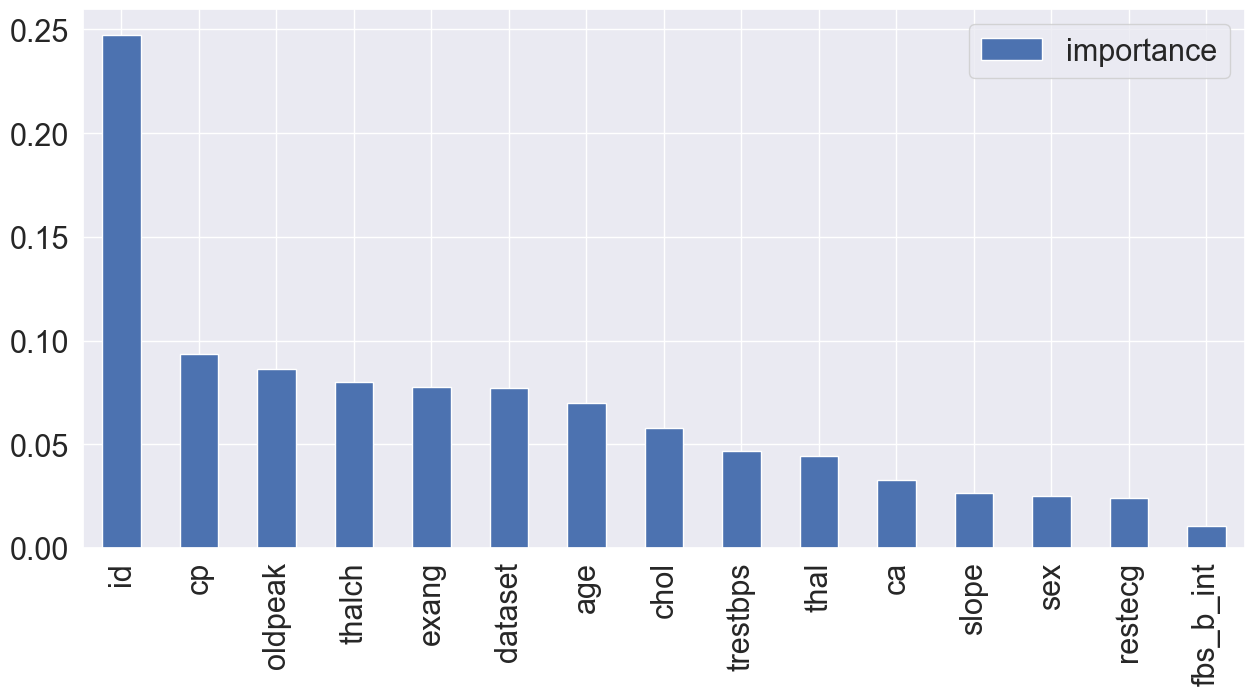

In [119]:
# посмотрим на важность признаков
sns.set(rc={"figure.figsize":(15, 7)}, font_scale=2)

feature_importances = pd.DataFrame(gs.best_estimator_.feature_importances_,
                                       index = features_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot(kind='bar') 
plt.show()

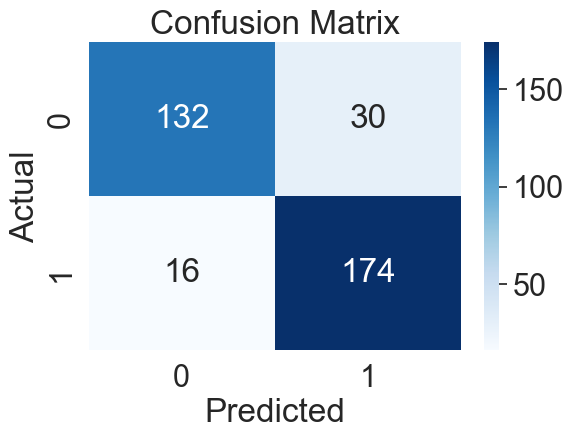

In [120]:
matrix = confusion_matrix(target_valid, predicted_valid)

plt.figure(figsize=(6,4))
sns.heatmap(matrix, annot=True, cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

Случайный лес с кросс валидацией дал результаты немного лучше, чем базовая модель.

### Общий вывод

В данном датасете присутствовали выбросы и пустые значения, а в результате анализа был составлен следующий портрет больного: 

* Крайне высокий рист стенокардии, возможно дальнейшее ухудшение работы сердца.
* При стенокардии максимальная частота сердечных сокращений ниже.
* Уровень холестерина меняется в зависимости от болезни сердца, чем диагноз сложнее, тем уровень холестерина выше. Есть так же здоровые люди, но с высоким уровнем холестерина. 
* Кровяное давление выше, чем у людей с отсутствием болезни. 

In [121]:
# Базовые модели
baseline_metrics

,Модель,Recall
0,Решающее дерево,0.821053
0,Лог. регрессия,0.831579
0,Случайный лес,0.905263


Исходя из значений Recall выбираем лучшую базовую модель и улучшаем ее. В нашем случае Случайный лес показал наилучший результат. Улучшим данное значение кроссвалидацией и балансировкой классов.

In [122]:
all_metrics

,Модель,Recall
0,balanced + cross_val Случайный лес,0.915789
